In [66]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch
import torch.nn.functional as F
import torch.optim as optimizers
import torch.nn as nn
from matplotlib import cm

In [45]:
import torchvision
import os
from PIL import Image
import glob
import torchvision.transforms as transforms

In [23]:
from torch.utils.data import Dataset,DataLoader
from PIL import Image, ImageDraw

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# データの取得
root = os.path.join('data', 'mnist')
transform = transforms.Compose([transforms.ToTensor(),
                                lambda x: x.view(-1)])
mnist_train =torchvision.datasets.MNIST(root=root,
                                      download=True,
                                      train=True,
                                      transform=transform)
mnist_test = torchvision.datasets.MNIST(root=root,
                                      download=True,
                                      train=False,
                                      transform=transform)
train_dataloader = DataLoader(mnist_train,
                              batch_size=100,
                              shuffle=True)
test_dataloader = DataLoader(mnist_test,
                              batch_size=100,
                              shuffle=False)

In [5]:
class VAE(nn.Module):
    def __init__(self,device=device):
        super().__init__()
        self.device=device
        self.encoder=Encoder(device=device)
        self.decoder=Decoder(device=device)
    
    def forward(self,x):
        mean,var=self.encoder(x)
        z=self.reparameterize(mean,var)
        y=self.decoder(z)
        
        return y,z
    
    def reparameterize(self,mean,var):
        eps=torch.randn(mean.size()).to(self.device)
        z=mean+torch.sqrt(var)*eps
        return z
    
    def lower_bound(self,x):
        mean,var=self.encoder(x)
        z=self.reparameterize(mean,var)
        y=self.decoder(z)
        
        reconst=-torch.mean(torch.sum(x*torch.log(y)+(1-x)*torch.log(1-y),dim=1))
        
        kl=-torch.mean(torch.sum(1+torch.log(var)-mean**2-var,dim=1))/2
        
        L=reconst+kl
        
        return L
        
    

In [6]:
class Encoder(nn.Module):
    def __init__(self,device=device):
        super().__init__()
        self.device=device
        self.l1=nn.Linear(784,200)
        self.l_mean=nn.Linear(200,10)
        self.l_var=nn.Linear(200,10)
    def forward(self,x):
        h=self.l1(x)
        h=torch.relu(h)
        mean=self.l_mean(h)
        var=self.l_var(h)
        var=F.softplus(var)
        
        return mean,var

In [7]:
class Decoder(nn.Module):
    def __init__(self,device=device):
        super().__init__()
        self.device=device
        self.l1=nn.Linear(10,200)
        self.l2=nn.Linear(200,784)
    
    def forward(self,x):
        h=self.l1(x)
        h=torch.relu(h)
        h=self.l2(h)
        y=torch.sigmoid(h)
        return y
    

In [8]:
model=VAE(device=device).to(device)

criterion=model.lower_bound

optimizer=optimizers.Adam(model.parameters())


In [9]:
epochs=10

for epoch in range(epochs):
    train_loss=0
    for (x,_) in train_dataloader:
        x=x.to(device)
        model.train()
        
        loss=criterion(x)
        
        optimizer.zero_grad()
        
        loss.backward()
        
        optimizer.step()
        
        train_loss+=loss.item()
    
    train_loss/=len(train_dataloader)
    print('Epoch: {}, Loss: {:.3f}'.format(
        epoch+1,
        train_loss))
    

Epoch: 1, Loss: 169.335
Epoch: 2, Loss: 128.335
Epoch: 3, Loss: 122.891
Epoch: 4, Loss: 120.053
Epoch: 5, Loss: 118.269
Epoch: 6, Loss: 116.961
Epoch: 7, Loss: 116.002
Epoch: 8, Loss: 115.277
Epoch: 9, Loss: 114.620
Epoch: 10, Loss: 114.136


In [49]:
batch_size=8
z=torch.randn(batch_size,10,device=device)
model.eval()

im=model.decoder(z)
im=im.view(-1,28,28)
im=im.squeeze().detach().cpu().numpy()

In [51]:
print(im.shape)

(8, 28, 28)


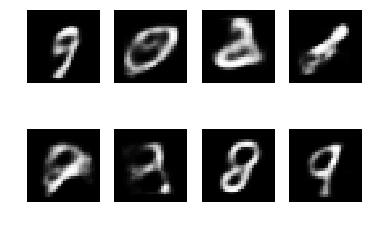

In [44]:
for i,im in enumerate(im):
    plt.subplot(2,4,i+1)
    plt.imshow(im,cmap='binary_r')
    plt.axis('off')

plt.tight_layout()
plt.show()

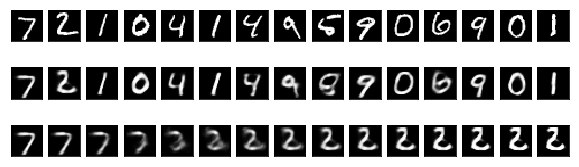

In [67]:
fig=plt.figure(figsize=(10,3))

model.eval()
ims=[]
for x,t in test_dataloader:
    for i,im in enumerate(x.view(-1,28,28).detach().cpu().numpy()[:15]):
        ax=fig.add_subplot(3,15,i+1,xticks=[],yticks=[])
        ax.imshow(im,'gray')
    x=x.to(device)
    y,z=model(x)
    y=y.view(-1,28,28)
    for i,im in enumerate(y.view(-1,28,28).detach().cpu().numpy()[:15]):
        ax=fig.add_subplot(3,15,i+16,xticks=[],yticks=[])
        ax.imshow(im,'gray')
        
    z1to0=torch.cat([z[1]*(i*0.1)+z[0]*((9-i)*0.1) for i in range(15)]).reshape(15,10)
    
    y2=model.decoder(z1to0).view(-1,28,28).cpu().detach().numpy()[:15]
    
    
    
    for i,im in enumerate(y2):
        ax=fig.add_subplot(3,15,i+31,xticks=[],yticks=[])
        imm=Image.fromarray(np.uint8(cm.gist_earth(im)*255))
        ims.append(imm)
        ax.imshow(im,'gray')
    
    break
    

In [70]:
ims[0].save('7to2.gif' , save_all = True , append_images = ims[1:] , duration = 400 , loop = 0)